### Fitting the image sharpness (DCTS metric) by ETL offset parameter
Example 1: A total of 5 images are acquired at various ETL offsets (near-optimal $v_0$, $v_0 \pm 200 mV$, $v_0 \pm 400 mV$), with R-arm, 488nm, 561nm illumination.

In [42]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile
import sys
import os
import time
import glob

In [2]:
utils_path = '../../../mesoSPIM/src/'
if os.path.exists(utils_path):
    sys.path.append('../../../mesoSPIM/src/')
else:
    print('Error: check your path to utils module')

In [3]:
from utils import optimization as opt

In [13]:
img_folder = '../fixtures/etl/region0-right-arm/'
tif_files = glob.glob(img_folder + "*.tif")
meta_files = [ fname + "_meta.txt" for fname in tif_files]

In [32]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

In [91]:
meta_list = []

for tif, meta in zip(tif_files, meta_files):
    meta_dict = {}
    with open(meta) as f:
        lines = nonblank_lines(f)
        for line in lines:
            if line.split()[0] == "[Zoom]":
                meta_dict["zoom"] = line.split()[1]
            elif line.split()[0] == "[Shutter]":
                meta_dict["shutter"] = line.split()[1]
            elif line.split()[0] == "[etl_l_offset]":
                meta_dict["etl_l_offset"] = float(line.split()[1])
            elif line.split()[0] == "[etl_r_offset]":
                meta_dict["etl_r_offset"] = float(line.split()[1])
            elif line.split()[0] == "[Laser]":
                meta_dict["laser"] = line.split()[1]
    meta_dict["tif"] = tif
    meta_list.append(meta_dict)

In [92]:
meta_list[0]

{'laser': '488',
 'zoom': '1x',
 'shutter': 'Right',
 'etl_l_offset': 2.3939999999999975,
 'etl_r_offset': 2.5339999999999963,
 'tif': '../fixtures/etl/region0-right-arm\\20210629-114659.tif'}

In [46]:
dim_y, dim_x = tifffile.imread(meta_list[0]['tif']).shape
print(dim_y, dim_x)

2048 2048


In [61]:
roi_perc = 20. # how much percent of the image width does the ROI occupy.
slice_x = slice(int(dim_x * (50 - roi_perc/2)/100), int(dim_x * (50 + roi_perc/2)/100))

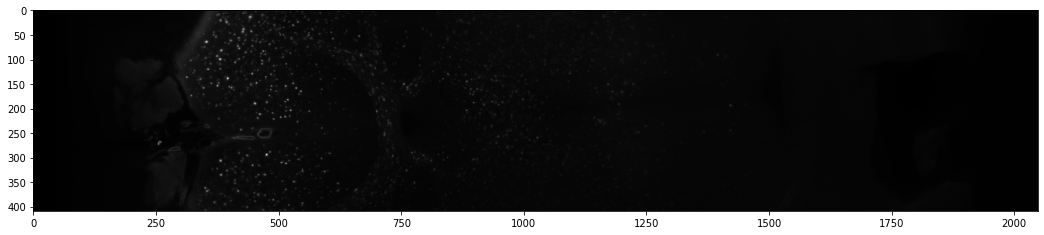

In [64]:
img = tifffile.imread(meta_list[0]['tif'])

plt.figure(figsize=(18,6))
plt.imshow(img[:,slice_x].T, cmap='gray')

In [95]:
list_488_r = [m for m in meta_list if (m['laser']=='488' and m['shutter']=='Right')]
list_561_r = [m for m in meta_list if (m['laser']=='561' and m['shutter']=='Right')]

In [116]:
roi_metrics_488_r = []
etl_offsets_488_r = []

roi_metrics_561_r = []
etl_offsets_561_r = []

for exp in list_488_r:
    roi = tifffile.imread(exp['tif'])[:,slice_x]
    roi_metrics_488_r.append(opt.shannon_dct(roi))
    etl_offsets_488_r.append(exp['etl_r_offset'])
    
for exp in list_561_r:
    roi = tifffile.imread(exp['tif'])[:,slice_x]
    roi_metrics_561_r.append(opt.shannon_dct(roi))
    etl_offsets_561_r.append(exp['etl_r_offset'])

In [103]:
# sort the data points and fit them
etl_offsets_sort = sorted(etl_offsets_488_r)
roi_metrics_sort = [ m for o, m in sorted(zip(etl_offsets_488_r, roi_metrics_488_r))]

f_points, x_points = np.array(roi_metrics_sort), np.array(etl_offsets_sort)
fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(f_points, x_points)
parab_fit_center, parab_fit_amp, parab_fit_offset = opt.fit_parabola_1d(f_points, x_points)

Text(0.5, 1.0, 'ROI sharpness metric (ex.488nm, Right)')

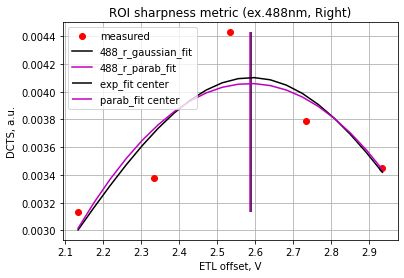

In [115]:
key = '488_r'
etl_offset_grid = np.linspace(etl_offsets_sort[0], etl_offsets_sort[-1], 20)

plt.plot(etl_offsets_sort, roi_metrics_sort, "or", label="measured")

plt.plot(etl_offset_grid, opt._gaussian_1d(etl_offset_grid, fit_center, fit_sigma, fit_amp, fit_offset), 'k', 
        label=key + "_gaussian_fit",)

plt.plot(etl_offset_grid, opt._parabola_1d(etl_offset_grid, parab_fit_center, parab_fit_amp, parab_fit_offset), 'm', 
        label=key + "_parab_fit",)

plt.vlines(fit_center, f_points.min(), f_points.max(), 'k', label="exp_fit center")
plt.vlines(parab_fit_center, f_points.min(), f_points.max(), 'm', label="parab_fit center")
   
plt.grid(True)
plt.legend() 
plt.legend(loc='upper left')
plt.ylabel("DCTS, a.u.")
plt.xlabel("ETL offset, V")
plt.title(f"ROI sharpness metric ({key})")

In [117]:
# 561, sort the data points and fit them
etl_offsets_sort = sorted(etl_offsets_561_r)
roi_metrics_sort = [ m for o, m in sorted(zip(etl_offsets_561_r, roi_metrics_561_r))]

f_points, x_points = np.array(roi_metrics_sort), np.array(etl_offsets_sort)
fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(f_points, x_points)
parab_fit_center, parab_fit_amp, parab_fit_offset = opt.fit_parabola_1d(f_points, x_points)

Text(0.5, 1.0, 'ROI sharpness metric (561_r)')

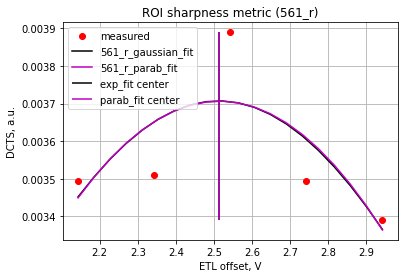

In [118]:
key = '561_r'
etl_offset_grid = np.linspace(etl_offsets_sort[0], etl_offsets_sort[-1], 20)

plt.plot(etl_offsets_sort, roi_metrics_sort, "or", label="measured")

plt.plot(etl_offset_grid, opt._gaussian_1d(etl_offset_grid, fit_center, fit_sigma, fit_amp, fit_offset), 'k', 
        label=key + "_gaussian_fit",)

plt.plot(etl_offset_grid, opt._parabola_1d(etl_offset_grid, parab_fit_center, parab_fit_amp, parab_fit_offset), 'm', 
        label=key + "_parab_fit",)

plt.vlines(fit_center, f_points.min(), f_points.max(), 'k', label="exp_fit center")
plt.vlines(parab_fit_center, f_points.min(), f_points.max(), 'm', label="parab_fit center")
   
plt.grid(True)
plt.legend() 
plt.legend(loc='upper left')
plt.ylabel("DCTS, a.u.")
plt.xlabel("ETL offset, V")
plt.title(f"ROI sharpness metric ({key})")

### Conclusions so far
- the image sharpness response seems to be asymmetric in respect to ETL offset. Collect data with smaller grid steps (50 mV).
- the image sharpness metric seems to have enough dynamic range, the optimum clearly stands out
- gaussian and parabolic fits give nearly identical results